In [1]:
import copy
import numpy as np

In [2]:
%matplotlib inline

In [3]:
import matplotlib.gridspec as gridspec

import palettable

In [4]:
import verdict

In [5]:
import stained_glass.idealized as idealized
import stained_glass.stats as stats
import stained_glass.sample as sample

# Parameters

In [6]:
# Number of sightlines
n = 10000
r_clump = 6.
sidelength = 600.
r_bins = np.arange( 0., sidelength/2, 10.)
annuli = np.array([ 0., 90., 120., 150., 180., 210., 300., ])
levels = np.array([ 1., 2., 3., 4., 5., 6. ])
edges_log = np.logspace( -1., np.log10( sidelength) , 16 )
edges = np.linspace( 0., sidelength, 16 )

In [7]:
xs = edges[:-1] + 0.5 * ( edges[1] - edges[0] )

In [8]:
xs_log = 10.**( np.log10( edges_log[:-1] ) + 0.5 * ( np.log10( edges_log[1] ) - np.log10( edges_log[0] ) ) )

In [9]:
n_per_bin = round( n / (edges_log.size - 1 ) / 2 )

##### DEBUG
xs_log = xs
edges_log = edges

# Setup idealized projections

In [10]:
ips = []
all_length_scales = []

In [11]:
# Radial distribution
ip = idealized.IdealizedProjection(sidelength)
ip.add_ellipse(
    c = (0., 0.),
    a = 90.,
    value = levels[5],
)
length_scales = {}
length_scales['core'] = 90.

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for i, (struct, value) in enumerate( zip( *[ structs, values ] ) ):
    ip.add_concentric_structures(
        struct,
        value = levels[5],
        n_concentric = 4,
        dr = 30.,
    )

ips.append( ip )
all_length_scales.append( length_scales )

In [12]:
# Radial distribution and satellite
ip = idealized.IdealizedProjection(sidelength)
ip.add_ellipse(
    c = (0., 0.),
    a = 90.,
    value = levels[5],
)
length_scales = {}
length_scales['core'] = 90.
ip.add_ellipse(
    c = (180., 180.),
    a = 40.,
    value = levels[4],
)
length_scales['satellite'] = 40.

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for i, (struct, value) in enumerate( zip( *[ structs, values ] ) ):
    ip.add_concentric_structures(
        struct,
        value = levels[5],
        n_concentric = 4,
        dr = 30.,
    )

ips.append( ip )
all_length_scales.append( length_scales )

In [13]:
# Clumps
ip = idealized.IdealizedProjection(sidelength)
ip.add_clumps(
    r_clump = r_clump,
    c = (0., 0.),
    r_area = 150.,
    fcov = 0.5,
    value = levels[5],
)
length_scales = {}
length_scales['core'] = 150.
length_scales['clump'] = r_clump

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for i, (struct, value) in enumerate( zip( *[ structs, values ] ) ):
    ip.add_concentric_structures(
        struct,
        value = levels[5],
        n_concentric = 4,
        dr = 10.,
    )

ips.append( ip )
all_length_scales.append( length_scales )

In [14]:
# Filament
ip = idealized.IdealizedProjection(sidelength)
ip.add_curve(
    v1 = (0., 0.),
    v2 = (-300., 60.),
    theta_a = 20.,
    theta_b = 60.,
    value = levels[5],
)
length_scales = {}
length_scales['long'] = np.sqrt( 300.**2. + 60.**2. )

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for i, (struct, value) in enumerate( zip( *[ structs, values ] ) ):
    ip.add_concentric_structures(
        struct,
        value = levels[5],
        n_concentric = 4,
        dr = 30.,
    )

ips.append( ip )
all_length_scales.append( length_scales )

In [15]:
# All of the above
ip = idealized.IdealizedProjection(sidelength)
ip.add_ellipse(
    c = (0., 0.),
    a = 90.,
    value = levels[5],
)
length_scales = {}
length_scales['core'] = 90.
ip.add_ellipse(
    c = (180., 180.),
    a = 60.,
    value = levels[4],
)
length_scales['satellite'] = 60.
ip.add_clumps(
    r_clump = r_clump,
    c = (0., 0.),
    r_area = 150.,
    fcov = 0.5,
    value = levels[5],
)
length_scales['clump'] = r_clump
ip.add_curve(
    v1 = (0., 0.),
    v2 = (-300., 60.),
    theta_a = 20.,
    theta_b = 60.,
    value = levels[5],
)
length_scales['filament'] = np.sqrt( 300.**2. + 60.**2. )

structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
for i, (struct, value) in enumerate( zip( *[ structs, values ] ) ):
    ip.add_concentric_structures(
        struct,
        value = levels[5],
        n_concentric = 4,
        dr = 30.,
    )

ips.append( ip )
all_length_scales.append( length_scales )

In [16]:
# Add backgrounds
[ ip.add_background( levels[0] ) for ip in ips ]

[None, None, None, None, None]

In [17]:
# Generate Projections
[ ip.generate_idealized_projection() for ip in ips ]

[None, None, None, None, None]

# Calculate Metrics

In [18]:
all_tpcfs = {}

### Calculate weighted TPCF

In [19]:
tpcfs = []
means = []
for i, ip in enumerate( ips ):
    
    # Get data
    ip.generate_sightlines( n )
    ws = ip.evaluate_sightlines()
    coords = np.array([ ip.sl_xs, ip.sl_ys ]).transpose()
    
    tpcf, edges = stats.weighted_tpcf(
        coords,
        ws,
        edges_log,
    )
    
    tpcfs.append( tpcf )
    
    # Store the fiducially-sampled mean for more consistent normalization later
    means.append( np.nanmean( ws ) )
    
all_tpcfs[( 'W', )] = tpcfs

### Calculate radially-normalized, weighted TPCF

In [21]:
tpcfs = []
for i, ip in enumerate( ips ):
    
    # Get data
    ip.generate_sightlines( n )
    ws = ip.evaluate_sightlines()
    coords = np.array([ ip.sl_xs, ip.sl_ys ]).transpose()
    
    tpcf, edges = stats.radial_weighted_tpcf(
        coords,
        ws,
        edges_log,
        r_bins = r_bins,
    )
    
    tpcfs.append( tpcf )
    
all_tpcfs[( 'RN', 'W', )] = tpcfs

### Generate Paired Coordinates

In [22]:
v_edges = np.array([ ip.ip_values.min(), ip.ip_values.max() ])

In [23]:
pair_sampler = sample.PairSampler( ip.sidelength, edges_log, v_edges )
dr_coords1, dr_coords2 = pair_sampler.generate_pair_sampling_coords(
    n_per_bin = n_per_bin,
)

In [24]:
pair_coords = np.concatenate([ np.concatenate( dr_coords1 ), np.concatenate( dr_coords2 ) ])

In [25]:
# Get the normalizations using the means from non-paired sampling
means = np.array( means )
normalizations = means ** -2.

### Calculate radially-normalized, pair-sampled, weighted TPCF

In [26]:
tpcfs = []
for i, ip in enumerate( ips ):
    
    # Get data
    ip.set_sightlines( pair_coords )
    ws = ip.evaluate_sightlines()
    
    tpcf, edges = stats.radial_weighted_tpcf(
        pair_coords,
        ws,
        edges_log,
        r_bins = r_bins,
#         normalization = normalizations[i],
    )
    
    tpcfs.append( tpcf )
    
all_tpcfs[( 'RN', 'PS', 'W', )] = tpcfs

### Calculate annuli-binned, pair-sampled, weighted TPCF

In [27]:
tpcfs = []
annuli_medians = []
for i, ip in enumerate( ips ):
    
    # Get data
    ip.set_sightlines( pair_coords )
    ws = ip.evaluate_sightlines()
    
    tpcf, edges = stats.annuli_weighted_tpcf(
        pair_coords,
        ws,
        edges_log,
        r_bins = annuli,
#         normalization = normalizations[i],
    )
    
    tpcfs.append( tpcf )
    
    # Annuli medians for later use
    medians = []
    r = np.sqrt( ( pair_coords**2. ).sum( axis=1 ) )
    for i in range( len( annuli ) - 1 ):
        in_annuli = ( annuli[i] < r ) & ( r < annuli[i+1] ) 
        medians.append( np.nanmedian( ws[in_annuli] ) )
    annuli_medians.append( medians )
    
all_tpcfs[( 'A', 'PS', 'W', )] = tpcfs

/home/zhh137/repos/stained_glass/stained_glass/stats.py:363: RuntimeWarning: invalid value encountered in true_divide
  bin_average = bin_sum / dd
/home/zhh137/repos/stained_glass/stained_glass/stats.py:392: RuntimeWarning: invalid value encountered in true_divide
  result /= scaling


### Calculate pair-sampled, weighted TPCF

In [29]:
tpcfs = []
for i, ip in enumerate( ips ):
    
    # Get data
    ip.set_sightlines( pair_coords )
    ws = ip.evaluate_sightlines()
    
    tpcf, edges = stats.weighted_tpcf(
        pair_coords,
        ws,
        edges_log,
    )
    
    tpcfs.append( tpcf )
    
all_tpcfs[( 'PS', 'W', )] = tpcfs

### Calculate pair-sampled TPCF

tpcfs = []
for ip in ips:
    ip.evaluate_pair_sampled_tpcf(
        edges,
        0.5,
        4.5,
        estimator = 'simple',
        n_per_bin = n_per_bin,
    )
    tpcfs.append( tpcf )
    
all_tpcfs[( 'PS', )] = tpcfs

# Plot the Different Metrics

In [30]:
all_tpcfs = verdict.Dict( all_tpcfs )

In [31]:
global_min = all_tpcfs.apply( np.array ).apply( np.nanmin ).keymin()[1]
global_max = all_tpcfs.apply( np.array ).apply( np.nanmax ).keymax()[1]

In [32]:
ncols = len( ips )
nrows = 4

In [33]:
colors = palettable.cartocolors.qualitative.Safe_10.mpl_colors

In [34]:
def label_or_not( label, do_label ):
    
    if do_label:
        return label
    
    return None

/home/zhh137/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


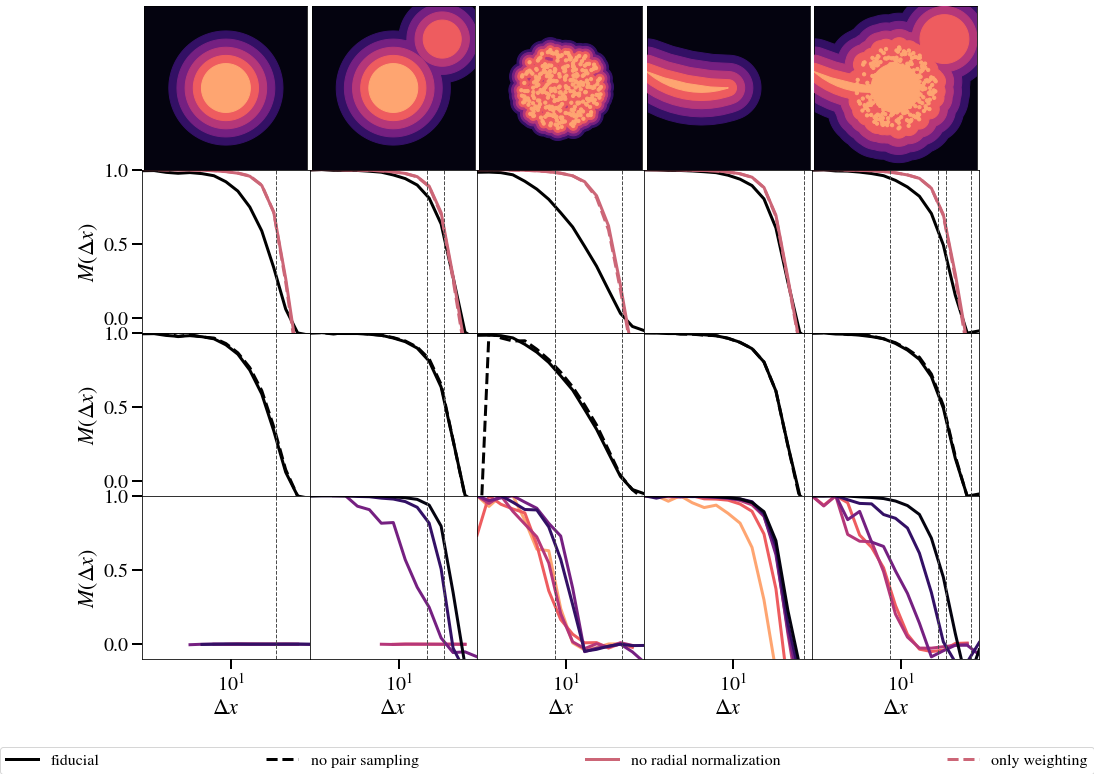

In [43]:
fig = plt.figure( figsize=(3*ncols, 3*nrows), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec( nrows, ncols )
gs.update( wspace=0.0001, hspace=0.0001 )

for i, ip in enumerate( ips ):
    
    # Plot the idealized image
    ax = plt.subplot( gs[0,i], )
    ip.plot_idealized_projection(
        ax,
    )
    
    # Fiducial
    ax = plt.subplot( gs[2,i], )
        
    # Plot Fiducial
    tpcf = all_tpcfs[( 'RN', 'PS', 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 3,
        color = 'k',
        label = label_or_not( 'fiducial', ax.is_first_col() )
    )
    
    # Plot w/o pair-sampling
    tpcf = all_tpcfs[( 'RN', 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 3,
        color = 'k',
        label = label_or_not( 'no pair sampling', ax.is_first_col() ),
        linestyle = '--',
    )
    
#     ax.set_ylim( -0.01, 5.0 )
    ax.set_ylim( -0.1, 1. )
    
    # Radial normalization comparison
    ax = plt.subplot( gs[1,i], )
    
    # Plot Fiducial
    tpcf = all_tpcfs[( 'RN', 'PS', 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 3,
        color = 'k',
    )
    
    # Plot w/o radial normalization
    tpcf = all_tpcfs[( 'PS', 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 3,
        color = colors[1],
        label = label_or_not( 'no radial normalization', ax.is_first_col() ),
    )
    
    # Plot only weighted
    tpcf = all_tpcfs[( 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 3,
        color = colors[1],
        linestyle = '--',
        label = label_or_not( 'only weighting', ax.is_first_col() ),
    )
    
#     ax.set_ylim( global_min, global_max )
    ax.set_ylim(-0.1, 1. )
    
    # Annuli
    ax = plt.subplot( gs[3,i], )
 
    # Plot w/o radial normalization
    tpcfs = all_tpcfs[( 'A', 'PS', 'W', )][i]
    values = levels[::-1]
    for k, tpcf in enumerate( tpcfs ):
        ax.plot(
            xs_log,
            tpcf,
            linewidth = 3,
            color = ip.color_chooser( values[k] ),
        )
    ax.set_ylim( -0.1, 1. )
    
# Go back through and fix up axes
for i in range( ncols ):
    for j in range( nrows ):
        
        ax = plt.subplot( gs[j,i], )
        
        # Projection Plot options
        if j < 1:
            
            ax.set_aspect( 'equal' )
            ax.tick_params( labelleft=False, labelbottom=False, left=False, bottom=False)
            
        # Statistics options
        if j >= 1:
            

            # Length scales
            for key, item in all_length_scales[i].items():
                ax.axvline(
                    item,
                    linewidth = 1.,
                    color = '.3',
                    linestyle = '--',
                )
            
            # Remove tick labels
            if not ax.is_first_col():
                ax.tick_params( labelleft=False, left=False, )
            if not ax.is_last_row():
                ax.tick_params( labelbottom=False, bottom=False, )
            ax.tick_params( which='minor', bottom=True, )
            
            # Limits for statistics
            ax.set_xlim( xs_log[0], xs_log[-1] )
#             ax.set_ylim( global_min, global_max )
            
            ax.set_xscale( 'log' )
#             ax.set_yscale( 'log' )
#             ax.set_yscale( 'symlog' )o
            
            if ax.is_last_row():
                ax.set_xlabel( r'$\Delta x$', fontsize=22 )
            if ax.is_first_col():
                ax.set_ylabel( r'$M(\Delta x)$', fontsize=22 )
          
#             # Legend
#             if ax.is_first_col():
#                 ax.legend(
#                     bbox_to_anchor = (0.0, 2.02, 5., 0.5 ),
#                     loc = 'lower left',
#                     ncol = 4,
#                     mode = "expand",
#                     borderaxespad = 0.,
#                     prop = {'size': 16},
#                 )

lgd = fig.legend(
#     bbox_to_anchor = (0.1, 0.87, 0.7, 1.0 ),
    loc = 'lower left',
    ncol = 4,
    mode = "expand",
    borderaxespad = 0.,
    prop = {'size': 16},
)

fig.savefig('./weighted_correlations.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

**Comment: The correlation function goes to 1 at the separation at which all values are the same within that separation. This is smaller than the size of the structure for which all values are the same.**

The multiple-per-halo statistics to consider are
[Radially-normalized], [pair-sampled], [weighted] TPCF [per cut on N].

~~The default should be with everything except for the N bins turned on.~~

~~One row will show the effect of turning on/off pair sampling (should be log-spaced).~~

One row will show the effect of turning on/off radial bins.

~~One row will show the effect of turning on/off radial-normalization.~~

One row will show the effect of turning off weighting.

**Issue: Depending on how the radial subtraction is done the normalization is different from the normalization when different annuli are done separately.**

**Issue: If radial trends are accounted for by division there shouldn't be values below one, but there are values below one.**

### Debug weighted TPCF